In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Input
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import os
from dotenv import load_dotenv


In [2]:
from pymongo import MongoClient

load_dotenv()
client = os.getenv("MONGO_URL")
client = MongoClient(client)
db = client["storage_simulation"]
collection = db["usage_logs"]



In [3]:
# Fetch all documents from the collection
cursor = collection.find()

# Convert to DataFrame
df = pd.DataFrame(list(cursor))
# Drop the '_id' column
df = df.drop(columns=['_id'])

# Convert 'timestamp' to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort by timestamp (optional but good for plotting)
df = df.sort_values(by='timestamp')

In [4]:
info_df = df[df['directory'] == '/info'].copy()
customer_df = df[df['directory'] == '/customer'].copy()
scratch_df = df[df['directory'] == '/scratch'].copy()
projects_df = df[df['directory'] == '/projects'].copy()

In [5]:
def create_sequences_singlestep(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])  # Just one value
    return np.array(X), np.array(y)

In [6]:
def build_lstm_model_singlestep(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(64, return_sequences=True),
        Dropout(0.25),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [7]:
def train_single_step_forecast_model(df, dir_name, sequence_length=96):

    print(f"\n📁 Processing directory: {dir_name} (Single-Step Forecast)")

    # Step 1: Preprocessing
    df.set_index('timestamp', inplace=True)
    df = df[['storage_gb']]
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df.values).flatten()


    X, y = create_sequences_singlestep(scaled_data, sequence_length)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # LSTM expects 3D
    y = y.reshape(-1, 1)

    # Step 3: Train-test split
    split_idx = int(len(X) * 0.8)
    X_train, y_train = X[:split_idx], y[:split_idx]
    X_test, y_test = X[split_idx:], y[split_idx:]

    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_lstm_model_singlestep(input_shape)

    # Step 5: Training
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=16,
        callbacks=[early_stop],
        verbose=0
    )

    # Step 6: Prediction
    y_pred = model.predict(X_test)
    y_pred_original = scaler.inverse_transform(y_pred)
    y_test_original = scaler.inverse_transform(y_test)

    # Step 7: Metrics
    mae = mean_absolute_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    data_range = y_test_original.max() - y_test_original.min()
    nmae = mae / data_range
    nrmse = rmse / data_range

    print(f"📊 {dir_name.upper()} - MAE: {mae:.2f} GB")
    print(f"📊 {dir_name.upper()} - RMSE: {rmse:.2f} GB")
    print(f"📊 {dir_name.upper()} - Normalized MAE: {nmae:.4f}")
    print(f"📊 {dir_name.upper()} - Normalized RMSE: {nrmse:.4f}")
    print("-" * 50)

    # Step 8: Plot
    plt.figure(figsize=(12, 5))
    plt.plot(y_test_original, label='Actual')
    plt.plot(y_pred_original, label='Predicted')
    plt.title(f"{dir_name.upper()} - Single-Step Forecast (Next Day End)")
    plt.xlabel("Test Sample Index")
    plt.ylabel("Storage (GB)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    models = os.path.abspath(os.path.join(os.getcwd(), '..', 'models'))
    os.makedirs(models, exist_ok=True)
    model.save(os.path.join(models, f"{dir_name}_daily_forecast_model.keras"))

    scalers = os.path.abspath(os.path.join(os.getcwd(), '..', 'scalers'))
    os.makedirs(scalers, exist_ok=True)
    scaler_file_path = os.path.join(scalers, f"{dir_name}_daily_scaler.pkl")
    joblib.dump(scaler, scaler_file_path)




📁 Processing directory: Project (Single-Step Forecast)
457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
📊 PROJECT - MAE: 16.28 GB
📊 PROJECT - RMSE: 20.78 GB
📊 PROJECT - Normalized MAE: 0.0223
📊 PROJECT - Normalized RMSE: 0.0285
--------------------------------------------------


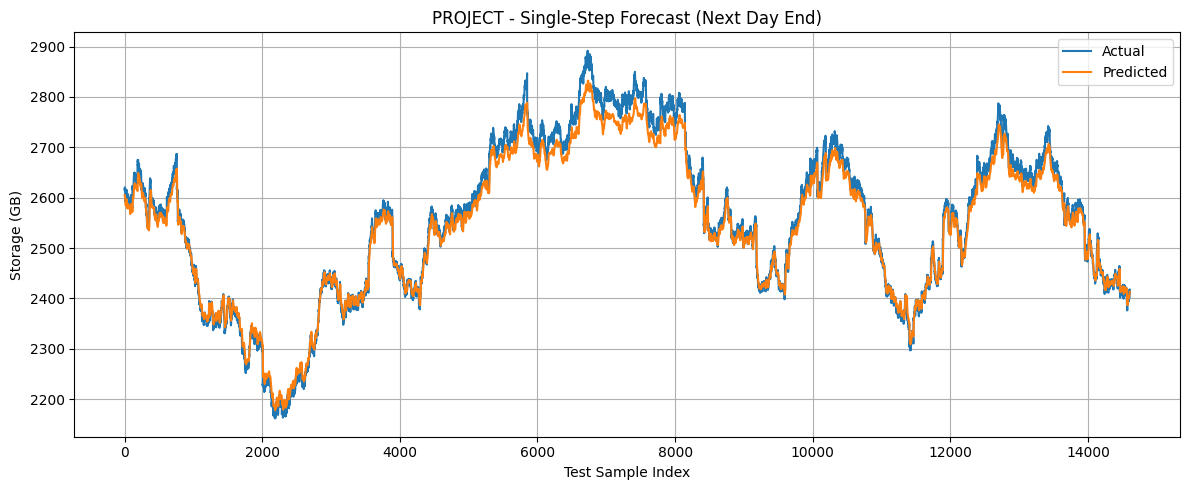

In [8]:
train_single_step_forecast_model(projects_df.copy(), dir_name='Project')


📁 Processing directory: Customer (Single-Step Forecast)
457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
📊 CUSTOMER - MAE: 3.24 GB
📊 CUSTOMER - RMSE: 4.99 GB
📊 CUSTOMER - Normalized MAE: 0.0073
📊 CUSTOMER - Normalized RMSE: 0.0112
--------------------------------------------------


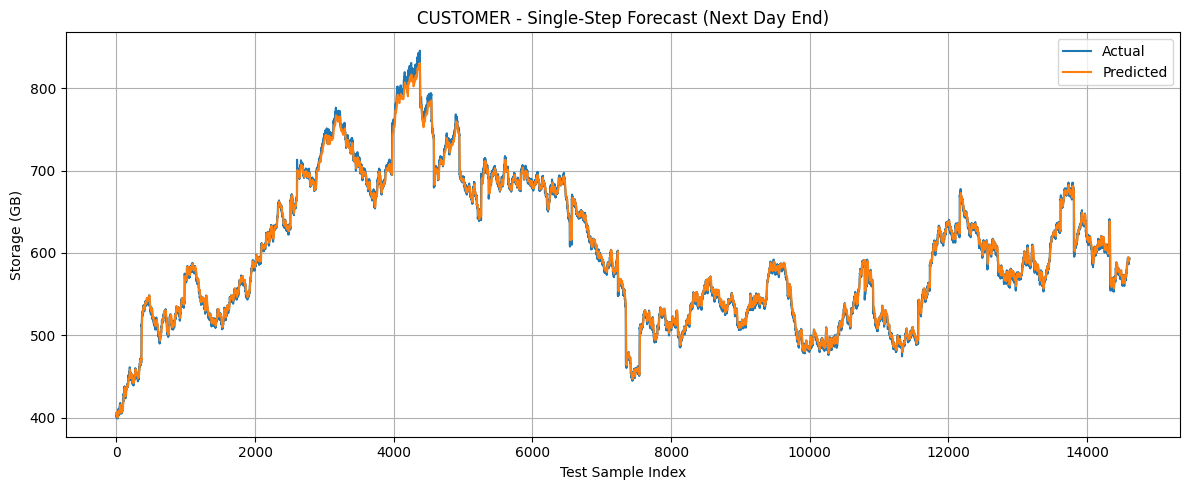

In [9]:
train_single_step_forecast_model(customer_df.copy(), dir_name='Customer')

In [ ]:
train_single_step_forecast_model(scratch_df.copy(), dir_name='Scratch')


📁 Processing directory: Scratch (Single-Step Forecast)


In [ ]:
train_single_step_forecast_model(info_df.copy(), dir_name='Info')